In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder,DatasetFolder
from torch.utils.data import DataLoader,random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from datetime import datetime
from tqdm.auto import tqdm
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

In [6]:
import torch.nn.functional as F
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.utils.data import Dataset, DataLoader,ConcatDataset

In [3]:
# Función "collate" personalizada que utiliza el feature extractor
model2_repo_id = 'google/vit-base-patch16-224-in21k'
model2_feature_extractor = ViTFeatureExtractor.from_pretrained(model2_repo_id)

# Definir la transformación para las imágenes
rgb_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convertir imágenes de escala de grises a 3 canales (RGB)                 # Redimensionar al tamaño requerido por ViT
])

/home/mitchellmirano/Desktop/MitchellProjects/TesisMaestria/src/SkyrmionClassifier/.venv/lib/python3.14/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
experimento = "experimento1 images"
dataset_data_dir = f"/home/mitchellmirano/Desktop/MitchellProjects/H vs J phase diagram/{experimento}"
results_path = "/home/mitchellmirano/Desktop/MitchellProjects/TesisMaestria/results/SkyrmionClassifier"

In [5]:
class MyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [os.path.join(root, img) for img in os.listdir(root)]


    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]

        return image_path,Image.open(image_path)


In [6]:
def model2_collate_fn(batch):
    # Separa las imágenes y etiquetas
    paths, images = zip(*batch)
    # Aplica el feature extractor a la lista de imágenes (se espera que sean objetos PIL.Image)
    inputs = model2_feature_extractor(list(images), return_tensors="pt")
    return paths,inputs

In [7]:
batch_size = 32
my_dataset = MyDataset(root=dataset_data_dir, transform=rgb_transform)
data_loader = DataLoader(my_dataset, batch_size=batch_size,collate_fn=model2_collate_fn)

In [8]:
with open(Path(results_path)/'classes/id2label_vit.json', 'r') as f:
    id2label = json.load(f)

with open(Path(results_path)/'classes/label2id_vit.json', 'r') as f:
    label2id = json.load(f)

In [9]:
# Cargar el modelo ViT
model = torch.load(Path(results_path)/'models/model_vit.pth',weights_only=False)
# Configurar el dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [10]:
for batch in data_loader:
    batch_paths, batch_inputs = batch
    model2_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
    outputs = model(**model2_inputs)
    probabilities = F.softmax(outputs.logits, dim=1)
    predictions = torch.argmax(outputs.logits, dim=-1)
    print(probabilities)
    print(predictions)
    break

tensor([[0.5708, 0.1976, 0.1297, 0.1018],
        [0.5750, 0.1953, 0.1281, 0.1015],
        [0.2565, 0.3281, 0.2345, 0.1809],
        [0.1501, 0.2868, 0.3232, 0.2400],
        [0.5764, 0.1938, 0.1285, 0.1013],
        [0.5763, 0.1945, 0.1282, 0.1010],
        [0.1543, 0.2808, 0.3753, 0.1896],
        [0.2273, 0.3423, 0.2588, 0.1716],
        [0.1561, 0.2488, 0.3988, 0.1964],
        [0.5652, 0.2025, 0.1290, 0.1032],
        [0.5778, 0.1929, 0.1287, 0.1006],
        [0.4522, 0.2820, 0.1555, 0.1103],
        [0.5704, 0.1983, 0.1292, 0.1021],
        [0.5687, 0.1992, 0.1300, 0.1022],
        [0.5752, 0.1941, 0.1288, 0.1018],
        [0.5730, 0.1962, 0.1285, 0.1022],
        [0.1541, 0.2383, 0.3209, 0.2867],
        [0.5756, 0.1938, 0.1292, 0.1014],
        [0.1991, 0.4192, 0.2060, 0.1757],
        [0.5759, 0.1938, 0.1290, 0.1013],
        [0.1795, 0.2607, 0.3282, 0.2315],
        [0.5778, 0.1935, 0.1276, 0.1011],
        [0.5727, 0.1961, 0.1287, 0.1024],
        [0.5756, 0.1942, 0.1288, 0

In [11]:
id2label

{'0': 'F', '1': 'S', '2': 'Sk', '3': 'V'}

In [12]:
model.eval()

all_preds = []
all_images = []
all_probs = []

start = datetime.now()

with torch.no_grad():
    pbar = tqdm( data_loader, desc="Evaluación", total=len(data_loader), leave=False)
    for model2_batch in pbar:
        batch_paths,batch_inputs= model2_batch
        model2_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
        
        # Obtener las salidas del modelo
        outputs = model(**model2_inputs)

        # Calcular las probabilidades usando softmax
        probabilities = F.softmax(outputs.logits, dim=1)

        # Obtener las predicciones
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Guardar las predicciones, etiquetas y probabilidades
        all_preds.extend(predictions.cpu().numpy())
        all_images.extend(batch_paths)
        all_probs.extend(probabilities.cpu().numpy())

end = datetime.now()
delta = end - start
print(f"Inference time: {delta.total_seconds()/60:.3f} minutes")


Evaluación:   0%|          | 0/313 [00:00<?, ?it/s]

Inference time: 5.863 minutes


In [13]:
import pandas as pd

In [14]:
import re

def extract_params(file_name):
    # Expresión Regular para capturar los valores
    # Explicación de la Regex:
    # (\w+) : Captura la etiqueta (N, J2, K, H, T) en el grupo 1
    # \s*=\s* : Coincide con el patrón de ' = ' (cero o más espacios, =, cero o más espacios)
    # ([\d\.]+) : Captura el valor numérico (dígitos y puntos decimales) en el grupo 2
    pattern = r"(\w+)\s*=\s*([\d\.]+)"
    
    # Encontrar todas las coincidencias en el nombre del archivo
    matches = re.findall(pattern, file_name)
    
    # Crear un diccionario para almacenar los resultados
    parameters = {}
    for key, value in matches:
        # Convertir los valores a float si es posible, o a int para N
        if key == 'N':
            parameters[key] = int(value)
        else:
            parameters[key] = float(value)

    return parameters

In [15]:

images = [image.split("/")[-1] for image in all_images ] 
images

['skyrmionsPlot N = 547 J2 = 0.6272727272727273 K = 0.1 H = 1.7575757575757576 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.5060606060606061 K = 0.1 H = 0.787878787878788 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.8333333333333333 K = 0.1 H = 0.0 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.8878787878787879 K = 0.1 H = 1.7878787878787876 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.43333333333333335 K = 0.1 H = 1.0909090909090908 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.6636363636363637 K = 0.1 H = 2.212121212121212 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.5606060606060606 K = 0.1 H = 0.30303030303030304 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.8515151515151516 K = 0.1 H = 2.090909090909091 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.6151515151515152 K = 0.1 H = 0.2727272727272727 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.6212121212121212 K = 0.1 H = 1.3636363636363635 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.3 K = 0.1 H = 1.242424242

In [16]:
id2label = {int(i):k for i, k in id2label.items()}
id2label

{0: 'F', 1: 'S', 2: 'Sk', 3: 'V'}

In [17]:
probs_df = pd.DataFrame(np.array(all_probs).round(3), columns=[label for label in list(id2label.values())])
probs_df

,F,S,Sk,V
0,0.571,0.198,0.130,0.102
1,0.575,0.195,0.128,0.102
2,0.256,0.328,0.235,0.181
3,0.150,0.287,0.323,0.240
4,0.576,0.194,0.128,0.101
...,...,...,...,...
9995,0.156,0.279,0.375,0.190
9996,0.210,0.399,0.214,0.177
9997,0.574,0.194,0.130,0.101
9998,0.162,0.278,0.370,0.189


In [19]:
df = pd.DataFrame({'experimento': len(images)*[experimento]})
df['image'] = images

Ns = []
J2s = []
Ks = []
Hs = []
Ts = []
for image in df['image']:
    params = extract_params(image)
    Ns.append(params['N'])
    J2s.append(params['J2'])
    Ks.append(params['K'])
    Hs.append(params['H'])
    Ts.append(params['T'])
df['N'] = Ns
df['K'] = Ks
df['T'] = Ts
df['H'] = Hs
df['J2'] = J2s
df = pd.concat([df, probs_df], axis=1)
df['id'] = all_preds
df['label'] = df['id'].map(id2label)
df.to_excel(Path(results_path)/f'predictions/HvsJ_vit_inference_{experimento}.xlsx', index=False)
df

,experimento,image,N,K,T,H,J2,F,S,Sk,V,id,label
0,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6272727272727273 ...,547,0.1,0.01,1.757576,0.627273,0.571,0.198,0.130,0.102,0,F
1,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5060606060606061 ...,547,0.1,0.01,0.787879,0.506061,0.575,0.195,0.128,0.102,0,F
2,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8333333333333333 ...,547,0.1,0.01,0.000000,0.833333,0.256,0.328,0.235,0.181,1,S
3,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8878787878787879 ...,547,0.1,0.01,1.787879,0.887879,0.150,0.287,0.323,0.240,2,Sk
4,experimento1 images,skyrmionsPlot N = 547 J2 = 0.43333333333333335...,547,0.1,0.01,1.090909,0.433333,0.576,0.194,0.128,0.101,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5666666666666667 ...,547,0.1,0.01,0.212121,0.566667,0.156,0.279,0.375,0.190,2,Sk
9996,experimento1 images,skyrmionsPlot N = 547 J2 = 0.4696969696969696 ...,547,0.1,0.01,0.060606,0.469697,0.210,0.399,0.214,0.177,1,S
9997,experimento1 images,skyrmionsPlot N = 547 J2 = 0.3303030303030303 ...,547,0.1,0.01,1.393939,0.330303,0.574,0.194,0.130,0.101,0,F
9998,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6393939393939394 ...,547,0.1,0.01,0.606061,0.639394,0.162,0.278,0.370,0.189,2,Sk


In [8]:
df = pd.read_excel(Path(results_path)/f'predictions/HvsJ_vit_inference_{experimento}.xlsx')
df

,experimento,image,N,K,T,H,J2,F,S,Sk,V,id,label
0,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6272727272727273 ...,547,0.1,0.01,1.757576,0.627273,0.571,0.198,0.130,0.102,0,F
1,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5060606060606061 ...,547,0.1,0.01,0.787879,0.506061,0.575,0.195,0.128,0.102,0,F
2,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8333333333333333 ...,547,0.1,0.01,0.000000,0.833333,0.256,0.328,0.235,0.181,1,S
3,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8878787878787879 ...,547,0.1,0.01,1.787879,0.887879,0.150,0.287,0.323,0.240,2,Sk
4,experimento1 images,skyrmionsPlot N = 547 J2 = 0.43333333333333335...,547,0.1,0.01,1.090909,0.433333,0.576,0.194,0.128,0.101,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5666666666666667 ...,547,0.1,0.01,0.212121,0.566667,0.156,0.279,0.375,0.190,2,Sk
9996,experimento1 images,skyrmionsPlot N = 547 J2 = 0.4696969696969696 ...,547,0.1,0.01,0.060606,0.469697,0.210,0.399,0.214,0.177,1,S
9997,experimento1 images,skyrmionsPlot N = 547 J2 = 0.3303030303030303 ...,547,0.1,0.01,1.393939,0.330303,0.574,0.194,0.130,0.101,0,F
9998,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6393939393939394 ...,547,0.1,0.01,0.606061,0.639394,0.162,0.278,0.370,0.189,2,Sk


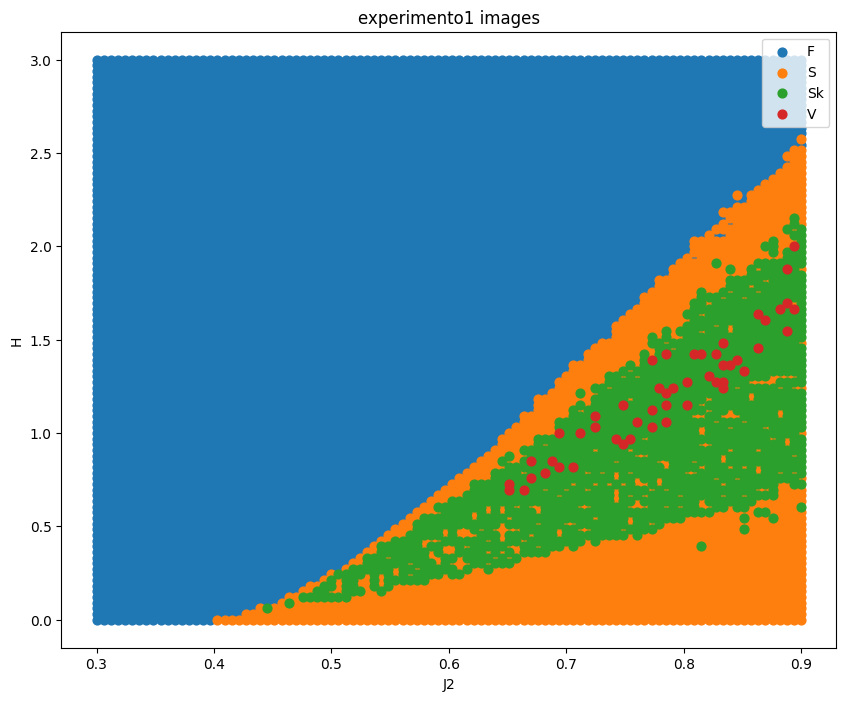

In [9]:
plt.figure(figsize=(10, 8))

for label, count in df['label'].value_counts( ascending=False).items():
    subset = df[df['label'] == label]
    plt.scatter(subset['J2'], subset['H'], label=label, s=40)
    
plt.xlabel('J2')
plt.ylabel('H')
plt.title(experimento)
plt.legend()
plt.savefig(Path(results_path)/f'predictions/HvsJ_vit_inference_{experimento}.png')
plt.show()

In [10]:
test_df=df[(df["label"]=='Sk') & (df["H"]<0.6) & (df["J2"]>=0.8)].copy()
test_df["images"] = [ os.path.join(dataset_data_dir, img) for img in test_df['image']]
test_df

,experimento,image,N,K,T,H,J2,F,S,Sk,V,id,label,images
27,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8090909090909091 ...,547,0.1,0.01,0.575758,0.809091,0.163,0.321,0.336,0.179,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
45,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8212121212121213 ...,547,0.1,0.01,0.575758,0.821212,0.135,0.227,0.440,0.198,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
1078,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8151515151515152 ...,547,0.1,0.01,0.575758,0.815152,0.137,0.250,0.394,0.218,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
2326,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8696969696969697 ...,547,0.1,0.01,0.575758,0.869697,0.168,0.319,0.338,0.175,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
2728,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8515151515151516 ...,547,0.1,0.01,0.545455,0.851515,0.165,0.300,0.353,0.182,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
3781,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8636363636363638 ...,547,0.1,0.01,0.575758,0.863636,0.169,0.314,0.332,0.185,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
3849,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8151515151515152 ...,547,0.1,0.01,0.393939,0.815152,0.213,0.279,0.288,0.220,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
4937,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8757575757575757 ...,547,0.1,0.01,0.545455,0.875758,0.171,0.311,0.338,0.179,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
6984,experimento1 images,skyrmionsPlot N = 547 J2 = 0.803030303030303 K...,547,0.1,0.01,0.575758,0.803030,0.134,0.269,0.414,0.182,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
7557,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8515151515151516 ...,547,0.1,0.01,0.484848,0.851515,0.207,0.301,0.326,0.166,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...


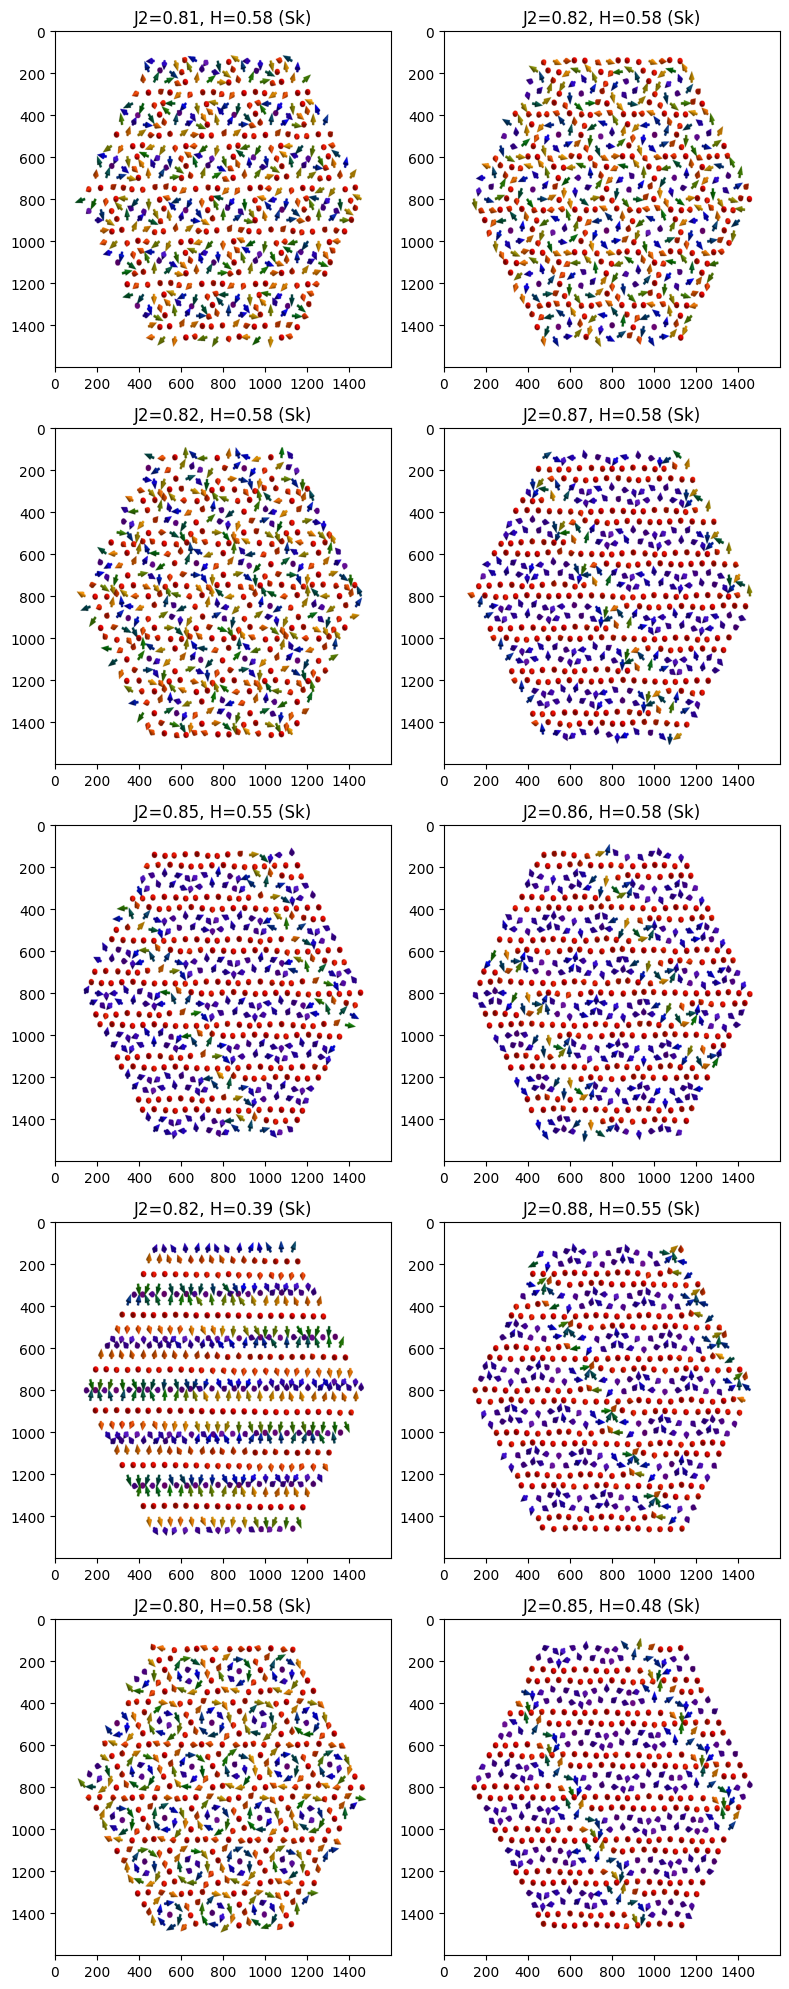

In [11]:
fig, ax = plt.subplots(len(test_df)//2, 2, figsize=(8, 2*len(test_df)))
for i, (index, row) in enumerate(test_df.iterrows()):
    ax[i//2, i%2].imshow(Image.open(row['images']))
    ax[i//2, i%2].set_title(f"J2={row['J2']:.2f}, H={row['H']:.2f} ({row['label']})")
    # ax[i//2, i%2].axis('off')
plt.tight_layout()